In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow_lattice as tfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..", "..", "..")))
from load_data import data_split

In [ ]:
choice = input("Choose dataset [filtered/raw]: ").strip().lower()

if choice == "filtered":
    relative_path = os.path.join("filtered_room_104.csv")
    Ns_t, Ne_t = 180, 190
elif choice == "original":
    relative_path = os.path.join("HVAC_B90_r104_exp_30m_20210727_15_min.csv")
    Ns_t, Ne_t = 530, 560
train_amount = int(input("Enter number of training samples (e.g., 100): "))
data = pd.read_csv(relative_path)
room, airflow, supply = data["r104_room_temp"], data["r104_airflow_current"], data["r104_supply_discharge_temp"]
start = 1
temp = np.array(room[start:-1]).reshape(-1, 1)
output = np.array(room[start+1:]).reshape(-1, 1)
air = np.array(airflow[start + 1:]).reshape(-1, 1)
supply = np.array(supply[start + 1:]).reshape(-1, 1)


def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

air = normalize(air)
supply = normalize(supply)
temp = normalize(temp)
output = normalize(output)

N_start, N_end = 1, train_amount
temp_tr, supply_tr, air_tr, output_tr = data_split(N_start, N_end, temp, supply, air, output)
temp_t, supply_t, air_t, output_t = data_split(Ns_t, Ne_t, temp, supply, air, output)

X = np.concatenate((temp_tr, supply_tr, air_tr), axis=1)
Y = np.copy(output_tr)
X_t = np.concatenate((temp_t, supply_t, air_t), axis=1)
Y_t = np.copy(output_t)

grid_size = 5
y_max = 2
k_folds = 10  
epochs = 100 
fold_no = 1
step = 30
decay = 0.8

In [ ]:

lrs = np.arange(0.01, 0.2, 0.01)
def pad_losses(loss_lists):
    max_len = max(len(lst) for lst in loss_lists)
    return np.array([lst + [np.nan] * (max_len - len(lst)) for lst in loss_lists])
best_lr = None
best_avg_val_loss = float("inf")
results = {}
for lr in lrs:
    print(f"Testing learning rate: {lr}")
    train_loss_history_all_folds = []
    val_loss_history_all_folds = []
    kf = KFold(n_splits=k_folds, shuffle=False)
    for train_index, val_index in kf.split(X):
        X_tr_fold, X_val_fold = X[train_index], X[val_index]
        Y_tr_fold, Y_val_fold = Y[train_index], Y[val_index]
        calibrators = [
            tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, y_max, grid_size), output_min=0, output_max=y_max),
            tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, y_max, grid_size), output_min=0, output_max=y_max, monotonicity="increasing"),
            tfl.layers.PWLCalibration(input_keypoints=np.linspace(0, y_max, grid_size), output_min=0, output_max=y_max)]
        combined_calibrators = tfl.layers.ParallelCombination(calibrators)
        lattice = tfl.layers.Lattice(lattice_sizes=[y_max + 1, y_max + 1, y_max + 1], monotonicities=["none", "increasing", "none"], output_min=0, output_max=1)
        
        inputs = tf.keras.Input(shape=(3,))
        calibrated_inputs = combined_calibrators(inputs)
        outputs = lattice(calibrated_inputs)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(ini_lr=lr, decay_steps=step, decay_rate=decay, staircase=True)
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=lr_schedule), metrics=["mse"])
        
        # Train model
        history = model.fit(X_tr_fold, Y_tr_fold, batch_size=Y_tr_fold.shape[0], epochs=epochs, validation_data=(X_val_fold, Y_val_fold), verbose=0)
        
        # Save loss history
        train_loss_history_all_folds.append(history.history["loss"])
        val_loss_history_all_folds.append(history.history["val_loss"])
    
    avg_val_loss = np.nanmean(pad_losses(val_loss_history_all_folds), axis=0)
    avg_final_val_loss = avg_val_loss[-1]
    results[lr] = avg_final_val_loss
    
    # Update best  rate
    if avg_final_val_loss < best_avg_val_loss:
        best_avg_val_loss = avg_final_val_loss
        best_lr = lr

# Print best learning rate
print(f"Best learning rate: {best_lr} with avg validation loss: {best_avg_val_loss}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='-', label='Avg Validation Loss')
plt.xlabel("Learning Rate")
plt.ylabel("Final Avg Validation Loss")
plt.xscale("log")
plt.title("Validation Loss vs Learning Rate")
plt.legend()
plt.grid(True)
plt.show()

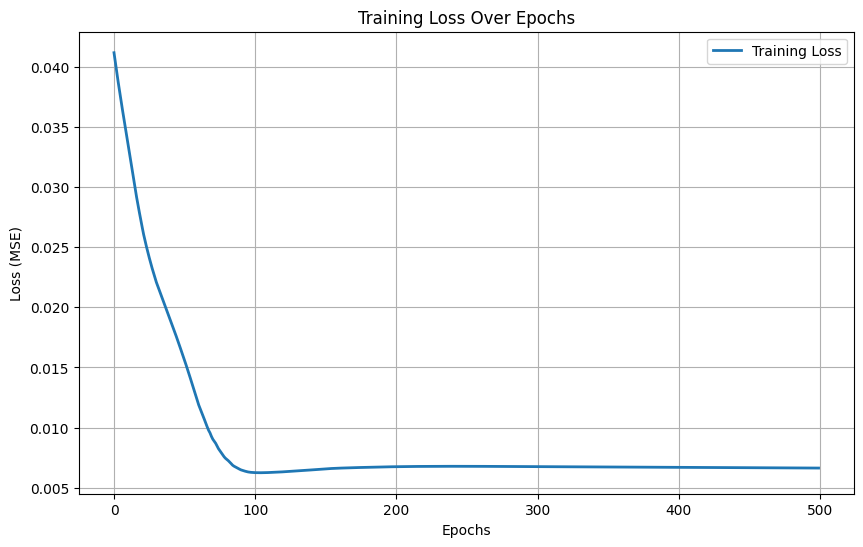

In [ ]:
lr = best_lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    ini_lr=lr,
    decay_steps=step,  
    decay_rate=decay,  
    staircase=True)
X_tr = np.concatenate((temp_tr, supply_tr, air_tr), axis=1)
Y_tr = np.copy(output_tr)

X_t = np.concatenate((temp_t, supply_t, air_t), axis=1)
Y_t = np.copy(output_t)

# Define model
calibrator_x1 = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0, y_max, grid_size),  # Linear mapping
    output_min=0,
    output_max=y_max
)
calibrator_x2 = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0, y_max, grid_size),  # Linear mapping with monotonicity
    output_min=0,
    output_max=y_max,
    monotonicity="increasing"
)
calibrator_x3 = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0, y_max, grid_size),  # Linear mapping
    output_min=0,
    output_max=y_max
)

combined_calibrators = tfl.layers.ParallelCombination([calibrator_x1, calibrator_x2, calibrator_x3])

lattice = tfl.layers.Lattice(
    lattice_sizes=[y_max + 1, y_max + 1, y_max + 1],
    monotonicities=["none", "increasing", "none"],
    output_min=0,
    output_max=1,
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-4)    # L2 regularization
)

inputs = tf.keras.Input(shape=(3,))
calibrated_inputs = combined_calibrators(inputs)
outputs = lattice(calibrated_inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

lattice_shape = np.prod(lattice.lattice_sizes)  
output_dim = 1 
lattice_weights = np.mean(Y_tr) * np.ones((lattice_shape, output_dim))
lattice.set_weights([lattice_weights])

optimizer = tf.keras.optimizers.Adam(lr=lr_schedule)
model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=optimizer,
    metrics=[tf.keras.metrics.MeanSquaredError()]
)
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)
# Train model
history = model.fit(
    x=X_tr,
    y=Y_tr,
    batch_size=Y_tr.shape[0],
    epochs=epochs,
    shuffle=False,
    verbose=0
)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
num = 3
r2 = []
mse = []
mae = []
X_t = np.concatenate((temp_t, supply_t, air_t), axis=1)
Y_t = np.copy(output_t)

Y_pred = model(tf.constant(X_t[:-num], dtype=tf.float32))
r2_con = r2_score(Y_t[:-num], Y_pred)
mse_con = mean_squared_error(Y_t[:-num], Y_pred)
mae_con = mean_absolute_error(Y_t[:-num], Y_pred)*5.9
r2.append(r2_con)
mse.append(mse_con)
mae.append(mae_con)

for i in range(1,num):
    X_t = np.concatenate((Y_pred, supply_t[i:i-num], air_t[i:i-num]), axis=1)
    Y_pred = model(tf.constant(X_t, dtype=tf.float32))
    r2_con = r2_score(Y_t[i:i-num], Y_pred)
    mse_con = mean_squared_error(Y_t[i:i-num], Y_pred)
    mae_con = mean_absolute_error(Y_t[i:i-num], Y_pred)*5.9
    r2.append(r2_con)
    mse.append(mse_con)
    mae.append(mae_con)
rmse = np.sqrt(mse)*5.9
print("R2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
df = pd.DataFrame({'rmse': rmse,'mae': mae,'r2': r2})
df = df.T
df.to_csv(f'results_lattice_{choice}_test_{N_end}.csv', index=True, header=True)

r2, mse, mae = [], [], []
X_tr = np.concatenate((temp_tr, supply_tr, air_tr), axis=1)
Y_tr = np.copy(output_tr)

Y_pred = model(tf.constant(X_tr[:-num], dtype=tf.float32))
r2_con = r2_score(Y_tr[:-num], Y_pred)
mse_con = mean_squared_error(Y_tr[:-num], Y_pred)
mae_con = mean_absolute_error(Y_tr[:-num], Y_pred)*5.9
r2.append(r2_con)
mse.append(mse_con)
mae.append(mae_con)

for i in range(1,num):
    X_tr = np.concatenate((Y_pred, supply_tr[i:i-num], air_tr[i:i-num]), axis=1)
    Y_pred = model(tf.constant(X_tr, dtype=tf.float32))
    r2_con = r2_score(Y_tr[i:i-num], Y_pred)
    mse_con = mean_squared_error(Y_tr[i:i-num], Y_pred)
    mae_con = mean_absolute_error(Y_tr[i:i-num], Y_pred)*5.9
    r2.append(r2_con)
    mse.append(mse_con)
    mae.append(mae_con)
rmse = np.sqrt(mse)*5.9
print("R2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
df = pd.DataFrame({'rmse': rmse,'mae': mae,'r2': r2})

df = df.T
df.to_csv(f'results_lattice_{choice}_train_{N_end}_.csv', index=True, header=True)

R2: [0.8206484193606916, 0.8127554845234661, 0.8185871871108299]
RMSE: [0.51183572 0.52870171 0.51786286]
MAE: [0.4082582165687977, 0.4217857813366661, 0.4081274144239066]


,0,1,2
rmse,0.511836,0.528702,0.517863
mae,0.408258,0.421786,0.408127
r2,0.820648,0.812755,0.818587
